<a href="https://colab.research.google.com/github/tbeucler/2023_SD_REP/blob/main/Figures_Tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We designed this notebook so that it can be run in Google Colab. To prepare the data, **please upload `RV_Zip_Count.csv`, `SVI_Redlining_Intersect.xlsx` and `Spatial_Join_SVI.dbf` in "Files"**.  

We will install the required Python libraries, pre-process the data, then calculate simple statistics, and finally reproduce the study's figures.

# Python Libraries Installation and Import

In [95]:
#@title Install the required libraries (we specify the version to facilitate reproducibility)
!pip install pandas==1.5.3
!pip install simpledbf==0.2.6
!pip install numpy==1.23.0
!pip install matplotlib==3.7.2
!pip install seaborn==0.12.2

In [96]:
#@title Import the required libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np

import pandas as pd

import seaborn as sns
import simpledbf
from simpledbf import Dbf5
from scipy.stats import ttest_ind
from scipy.stats import pearsonr

In [97]:
#@title Change font type to match JAMA style

# Font properties
plt.rcParams['font.size'] = 12

In [98]:
#@title Load the TTF Times New Roman font files and set as default font
font_paths = {
    'regular': '/content/times.ttf',
    'bold': '/content/timesbd.ttf',
    'italic': '/content/timesi.ttf',
    'bold_italic': '/content/timesbi.ttf',
}

font_props = {
    'regular': fm.FontProperties(fname=font_paths['regular']),
    'bold': fm.FontProperties(fname=font_paths['bold']),
    'italic': fm.FontProperties(fname=font_paths['italic']),
    'bold_italic': fm.FontProperties(fname=font_paths['bold_italic']),
}

# Register the fonts with Matplotlib
font_manager = fm.FontManager()
for font_style, font_prop in font_props.items():
    font_manager.ttflist.append(font_prop)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Data Pre-Processing

## Calculate the drop in Week 10-15 respiratory visits between 2016-2019 and 2020 per San Diego zipcode

In [99]:
# Read the data from a CSV file
rv_zip_count = pd.read_csv('RV_Zip_Count.csv')

In [100]:
# Duplicate rv_zip_count, but only keep 'week_of_year' from 10 to 15
rv_zip_count_week_10_15 = rv_zip_count[rv_zip_count['week_of_year'].isin([10, 11, 12, 13, 14, 15])]

In [101]:
# Per zip code and per year, sum all the patients from 'week_of_year' from 10 to 15
rv_zip_sum_week_10_15 = rv_zip_count_week_10_15.groupby(['zip', 'year'])['Number of patients'].sum().reset_index()

In [102]:
# Now average all years together except 2020
# Average all years together except 2020
diff = rv_zip_sum_week_10_15[rv_zip_sum_week_10_15['year'] != 2020]
diff = (diff.groupby('zip')['Number of patients'].sum()/4).reset_index()

In [103]:
# Replace the name of the column "Number of patients" with "2016-2019" in diff
diff.rename(columns={'Number of patients': '2016-2019'}, inplace=True)

In [104]:
# Extract the number of patients in 2020 from rv_zip_sum_week_10_15
rv_zip_2020 = rv_zip_sum_week_10_15[rv_zip_sum_week_10_15['year'] == 2020]

In [105]:
# Loop over zipcodes in diff to merge the 2016-2019 & 2020 visits in the same structure
# If the zipcode is in rv_zip_2020, assign rv_zip_2020['Number of patients'] to diff['2020']
for index, row in diff.iterrows():
  if row['zip'] in rv_zip_2020['zip'].values:
    diff.loc[index, '2020'] = rv_zip_2020.loc[rv_zip_2020['zip'] == row['zip']]['Number of patients'].values[0]
  else: diff.loc[index, '2020'] = 0.0

In [106]:
# Subtract the number of patients in diff from the number of patients in rv_zip_2020
# Divide weeks 10-15 by 6 to get weekly drop in pediatric respiratory visits
diff['six-week-diff'] = (diff['2020'] - diff['2016-2019'])
diff['drop_in_patients'] = -diff['six-week-diff']/6 # Per week
diff['relative_drop'] = -100*diff['six-week-diff']/diff['2016-2019'] # In % with respect to 2016-2019 average

In [107]:
# Only keep San Diego zipcodes
# Delete all rows corresponding to 'zip' greater than 92199 and smaller than 91901
diff = diff[(diff['zip'] <= 92199) & (diff['zip'] >= 91901)]

In [108]:
diff

,zip,2016-2019,2020,six-week-diff,drop_in_patients,relative_drop
149,91901,9.75,8.0,-1.75,0.291667,17.948718
150,91902,10.25,5.0,-5.25,0.875000,51.219512
151,91903,0.50,0.0,-0.50,0.083333,100.000000
152,91905,1.25,0.0,-1.25,0.208333,100.000000
153,91906,4.50,4.0,-0.50,0.083333,11.111111
...,...,...,...,...,...,...
273,92177,0.25,1.0,0.75,-0.125000,-300.000000
274,92178,0.25,1.0,0.75,-0.125000,-300.000000
275,92192,0.50,0.0,-0.50,0.083333,100.000000
276,92196,0.25,0.0,-0.25,0.041667,100.000000


## Pre-Process database containing spatially-joined zipcodes and CDC social vulnerability indices

In [109]:
# Path to the spatially-joined zipcode and SVIs
path_dbf = '/content/Spatial_Join_Zip_SVI.dbf'

In [110]:
dbf = Dbf5(path_dbf) # Load dbf file
svi = dbf.to_dataframe() # Convert to pd dataframe
svi['zip'] = svi['zip'].astype('int') # Convert zipcodes to integers
svi = svi.replace(-999, np.nan) # Replace -999 values with NaN following CDC conventions

In [111]:
#@title Group SVI statistics by zip code
svi_zip = {}
svi_zip['zipcode'] = svi.groupby('zip')['zip'].unique().astype('int')

svi_zip['all_median'] = svi.groupby('zip')['RPL_THEMES'].median()
svi_zip['socioeconomic_median'] = svi.groupby('zip')['RPL_THEME1'].median()
svi_zip['household_median'] = svi.groupby('zip')['RPL_THEME2'].median()
svi_zip['minority_median'] = svi.groupby('zip')['RPL_THEME3'].median()
svi_zip['housing_median'] = svi.groupby('zip')['RPL_THEME4'].median()

svi_zip['all_mean'] = svi.groupby('zip')['RPL_THEMES'].mean()
svi_zip['socioeconomic_mean'] = svi.groupby('zip')['RPL_THEME1'].mean()
svi_zip['household_mean'] = svi.groupby('zip')['RPL_THEME2'].mean()
svi_zip['minority_mean'] = svi.groupby('zip')['RPL_THEME3'].mean()
svi_zip['housing_mean'] = svi.groupby('zip')['RPL_THEME4'].mean()

svi_zip['all_min'] = svi.groupby('zip')['RPL_THEMES'].min()
svi_zip['socioeconomic_min'] = svi.groupby('zip')['RPL_THEME1'].min()
svi_zip['household_min'] = svi.groupby('zip')['RPL_THEME2'].min()
svi_zip['minority_min'] = svi.groupby('zip')['RPL_THEME3'].min()
svi_zip['housing_min'] = svi.groupby('zip')['RPL_THEME4'].min()

svi_zip['all_max'] = svi.groupby('zip')['RPL_THEMES'].max()
svi_zip['socioeconomic_max'] = svi.groupby('zip')['RPL_THEME1'].max()
svi_zip['household_max'] = svi.groupby('zip')['RPL_THEME2'].max()
svi_zip['minority_max'] = svi.groupby('zip')['RPL_THEME3'].max()
svi_zip['housing_max'] = svi.groupby('zip')['RPL_THEME4'].max()

In [112]:
# Convert svi_zip to a pandas dataframe
svi_zip = pd.DataFrame(svi_zip)

## Link mean weekly drop in respiratory visits to CDC social vulnerability indices

In [113]:
# Merge diff with svi_zip based on 'zip'
svi_zip_diff = svi_zip.merge(diff, on='zip')

## Preprocessing XSLX File Containing Overlapping Polygons Between Redlined Regions and Voting Districts with SVI Data

In [114]:
## Path containing the xslx file
path_xslx = '/content/SVI_Redlining_Intersect.xlsx'

In [115]:
# Loading the Excel file into a DataFrame
df_rlsvi = pd.read_excel(path_xslx)

# Displaying the first few rows to verify it's loaded correctly
print(df_rlsvi.head())

   OBJECTID  FID_holc_a state    city name holc_id holc_grade  neighborho  \
0         1         175    CA  Fresno           A1          A       604.0   
1         2         175    CA  Fresno           A1          A       604.0   
2         3         176    CA  Fresno           A2          A       605.0   
3         4         177    CA  Fresno           B1          B       608.0   
4         5         177    CA  Fresno           B1          B       608.0   

                                          area_descr FID_SVI202  ... EP_NHPI  \
0  { ""1"" : ""This is the best residential distr...        829  ...     0.0   
1  { ""1"" : ""This is the best residential distr...        830  ...     0.0   
2  { ""1"" : ""This small area stands out definit...        803  ...     0.4   
3  { ""1"" : ""This is an area comprised entirely...        877  ...     0.0   
4  { ""1"" : ""This is an area comprised entirely...        879  ...     0.0   

  MP_NHPI EP_TWOMORE MP_TWOMORE EP_OTHERRA MP_OTHERRA Sh

In [116]:
df_rlsvi.rename(columns={
    'RPL_THEMES': 'all',
    'RPL_THEME1': 'socioeconomic',
    'RPL_THEME2': 'household',
    'RPL_THEME3': 'minority',
    'RPL_THEME4': 'housing'
}, inplace=True)

In [117]:
# Counting the number of -999 values in the DataFrame
count_neg_999 = (df_rlsvi == -999).sum().sum()
print(f"Number of -999 values in the DataFrame: {count_neg_999}")

# Replacing -999 values with NaN
df_rlsvi.replace(-999, np.nan, inplace=True)

Number of -999 values in the DataFrame: 1698


In [118]:
# Grouping the data by 'holc_grade' and calculating descriptive statistics for the SVIs
stats_by_holc_grade = df_rlsvi.groupby('holc_grade')[['all', 'socioeconomic', 'household', 'minority', 'housing']].describe()

# Displaying the statistics
print(stats_by_holc_grade)

               all                                                          \
             count      mean       std     min       25%     50%       75%   
holc_grade                                                                   
4              0.0       NaN       NaN     NaN       NaN     NaN       NaN   
A            401.0  0.225716  0.193421  0.0019  0.063700  0.1764  0.329500   
B           1124.0  0.394595  0.279044  0.0000  0.165425  0.3290  0.596000   
C           2221.0  0.603582  0.677541  0.0000  0.302400  0.5979  0.833600   
D           1146.0  0.656290  0.403751  0.0000  0.449300  0.7142  0.890525   

                    socioeconomic            ... minority         housing  \
                max         count      mean  ...      75%     max   count   
holc_grade                                   ...                            
4               NaN           1.0  2.600000  ...   0.8000  0.8000     0.0   
A            0.8690         404.0  0.233554  ...   0.4598  0.9948  

In [119]:
df_rlsvi

,OBJECTID,FID_holc_a,state,city,name,holc_id,holc_grade,neighborho,area_descr,FID_SVI202,...,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRA,MP_OTHERRA,Shape_Leng,Shape_Area,Unnamed: 170,Unnamed: 171
0,1,175,CA,Fresno,,A1,A,604.0,"{ """"1"""" : """"This is the best residential distr...",829,...,0.0,0.8,2.3,2.0,0.4,0.6,0.010676,7.078766e-06,NaN,NaN
1,2,175,CA,Fresno,,A1,A,604.0,"{ """"1"""" : """"This is the best residential distr...",830,...,0.0,0.9,1.9,1.6,0.0,0.9,0.028237,3.191464e-05,NaN,NaN
2,3,176,CA,Fresno,,A2,A,605.0,"{ """"1"""" : """"This small area stands out definit...",803,...,0.4,0.7,2.1,1.8,0.2,0.4,0.014593,1.025021e-05,NaN,NaN
3,4,177,CA,Fresno,,B1,B,608.0,"{ """"1"""" : """"This is an area comprised entirely...",877,...,0.0,0.8,3.5,3.9,0.0,0.8,0.003786,2.760261e-07,NaN,NaN
4,5,177,CA,Fresno,,B1,B,608.0,"{ """"1"""" : """"This is an area comprised entirely...",879,...,0.0,1.0,2.0,1.8,0.0,1.0,0.016012,1.417131e-05,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4925,4966,1038,CA,Stockton,Fair Oaks and Stribley Park,D5,D,892.0,"{ """"3n"""" : """"90 1936 12.50-22.50"""", """"3m""""...",7311,...,0.0,1.2,2.0,2.2,0.0,1.2,0.005609,1.241851e-07,NaN,NaN
4926,4967,1039,CA,Stockton,Westerm part Burkett Acres Community,D6,D,890.0,"{ """"2g"""" : """" Slowly """", """"3f"""" : """" 65 """", """"...",7311,...,0.0,1.2,2.0,2.2,0.0,1.2,0.022858,2.248002e-05,NaN,NaN
4927,4968,1040,CA,Stockton,,D7,D,877.0,"{ """"33"""" : """""""", """"3q"""" : """"Fair """", """"2c"""" :...",7295,...,0.0,0.8,1.3,1.3,0.1,0.1,0.025478,2.796929e-05,NaN,NaN
4928,4969,1041,CA,Stockton,,D8,D,880.0,"{ """"3c"""" : """" 27"""", """"3p"""" : """"25- fair """", ...",7295,...,0.0,0.8,1.3,1.3,0.1,0.1,0.036795,4.348237e-05,NaN,NaN


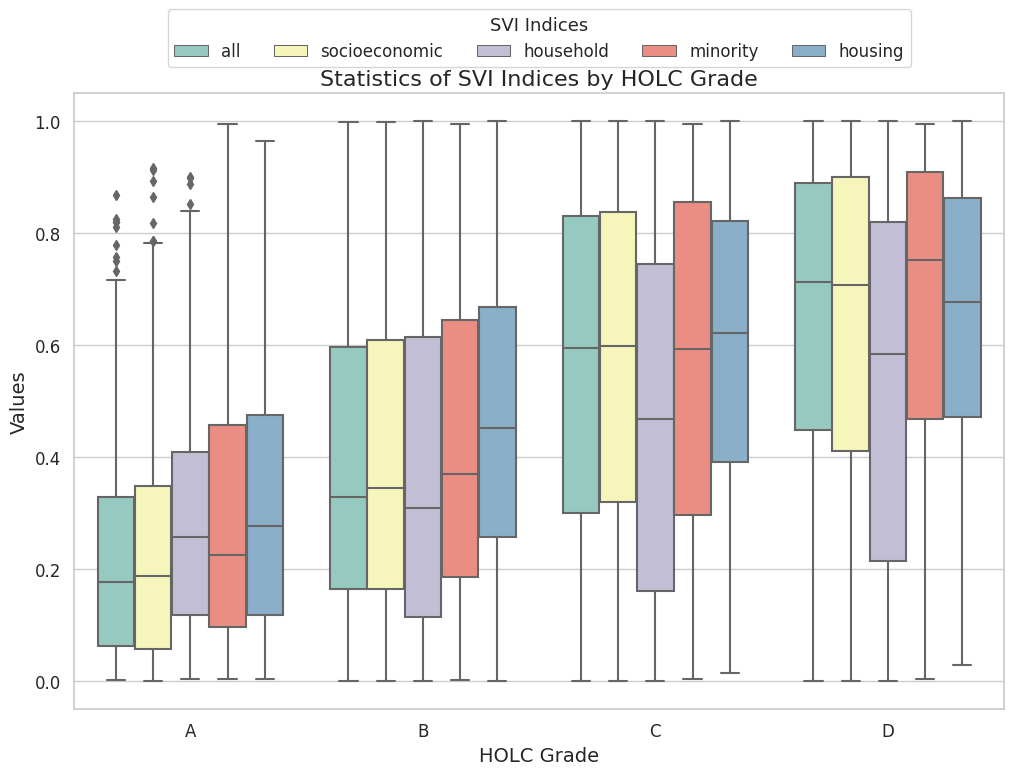

In [120]:
# Setting the style of the seaborn plots
sns.set(style="whitegrid")

# Define the columns to filter for 0<=SVI<=1
columns_to_filter = ['all', 'socioeconomic', 'household', 'minority', 'housing']

# Apply the filtering condition for each column individually and then combine the results
filtered_df = df_rlsvi[df_rlsvi[columns_to_filter].apply(lambda x: (x>=0) & (x<=1)).all(axis=1)]

# Preparing the data: Melting the DataFrame to have a long-format DataFrame suitable for seaborn's boxplot
df_melted = filtered_df.melt(id_vars=['holc_grade'], value_vars=['all', 'socioeconomic', 'household', 'minority', 'housing'],
                          var_name='RPL Theme', value_name='Value')

# Creating the boxplot
plt.figure(figsize=(12, 8))
boxplot = sns.boxplot(x='holc_grade', y='Value', hue='RPL Theme', data=df_melted, palette='Set3')

# Setting the title and labels for clarity
plt.title('Statistics of SVI Indices by HOLC Grade', fontsize=16)
plt.xlabel('HOLC Grade', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend(title='SVI Indices')

# Enhancing the plot for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='SVI Indices', loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=12, title_fontsize='13', ncol=len(df_melted['RPL Theme'].unique()))

plt.show()

In [121]:
# Create color dictionary that is consistent with the ArcGIS Pro colormaps
col_arcgis = {}
col_arcgis['blue'] = np.array([105, 158, 202])/255
col_arcgis['green'] = np.array([122, 195, 119])/255
col_arcgis['yellow'] = np.array([255, 255, 64])/255
col_arcgis['red'] = np.array([255, 62, 62])/255

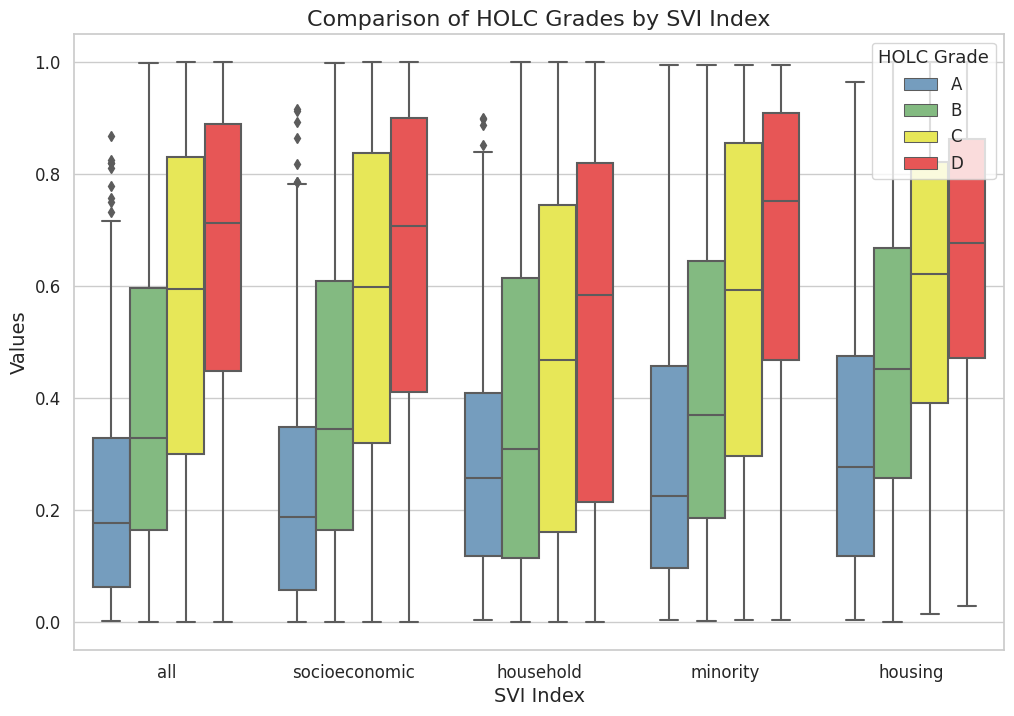

In [122]:
# Adjusting the plotting code to organize by RPL Theme and compare HOLC grades
plt.figure(figsize=(12, 8))
sns.boxplot(x='RPL Theme', y='Value', hue='holc_grade', data=df_melted,
            palette=[col_arcgis['blue'], col_arcgis['green'], col_arcgis['yellow'], col_arcgis['red']])

plt.title('Comparison of HOLC Grades by SVI Index', fontsize=16)
plt.xlabel('SVI Index', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='HOLC Grade', fontsize=12, title_fontsize='13', loc='upper right')

plt.show()

In [123]:
ax

<Axes: ylabel='SVI'>

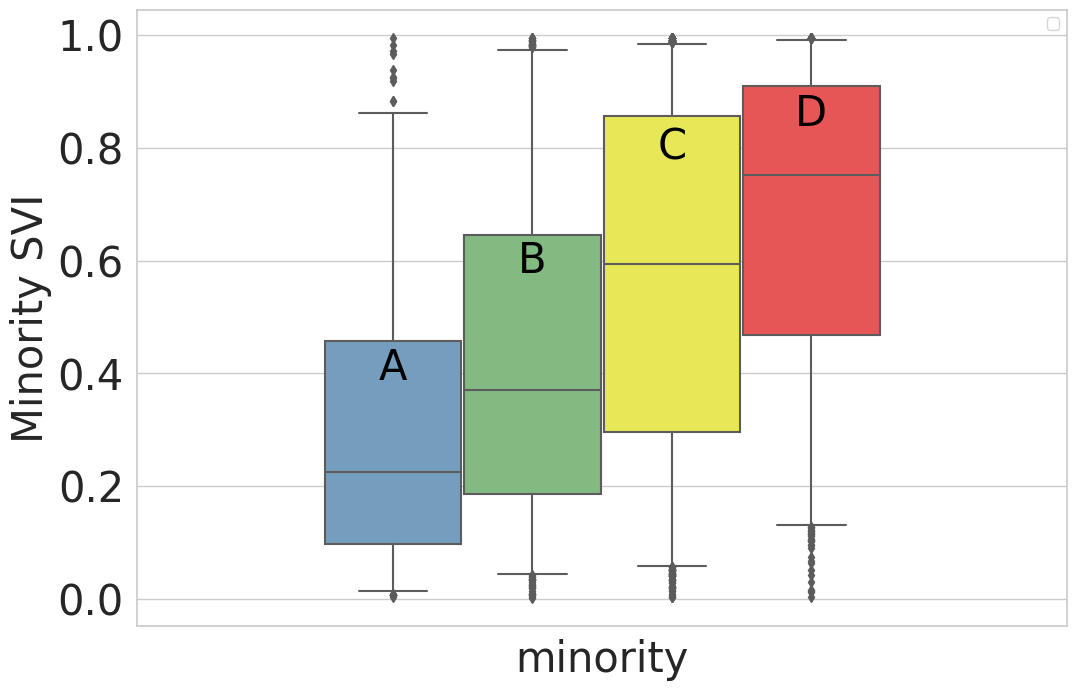

In [124]:
# Now, create the boxplot only for the 'minority' theme
plt.figure(figsize=(12, 8))  # Adjust the figure size to your preference
sns.boxplot(x='RPL Theme', y='Value', hue='holc_grade', data=minority_data,
            palette=[col_arcgis['blue'], col_arcgis['green'], col_arcgis['yellow'], col_arcgis['red']],
            whis=[2.5, 97.5],  # Set whiskers to the 2.5th and 97.5th percentiles
            width=0.6)  # Control box width

# Labels to be placed inside each box near the top
labels = ['A', 'B', 'C', 'D']

# Adjust these values as necessary
x_offsets = [-0.225,-0.075,0.075,0.225]  # Default x positions if seaborn places boxes starting at x=0, 1, 2, ...
y_offsets = [0.41,0.6,0.8,0.86]  # Approx. y positions based on data

for x_offset, y_offset, label in zip(x_offsets, y_offsets, labels):
    plt.text(x_offset, y_offset, label,  # Adjust y_offset as needed
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=30, color='black')

plt.title('')
plt.xlabel('')  # Remove the x-label
plt.ylabel('Minority SVI', fontsize=30)
plt.xticks(fontsize=30)  # Increase font size for tick labels
plt.yticks(fontsize=30)  # Increase font size for tick labels
# plt.legend(title='HOLC Grade', fontsize=18, title_fontsize='18', loc='upper left')
plt.legend('') # to avoid redundance in the final figure

plt.show()

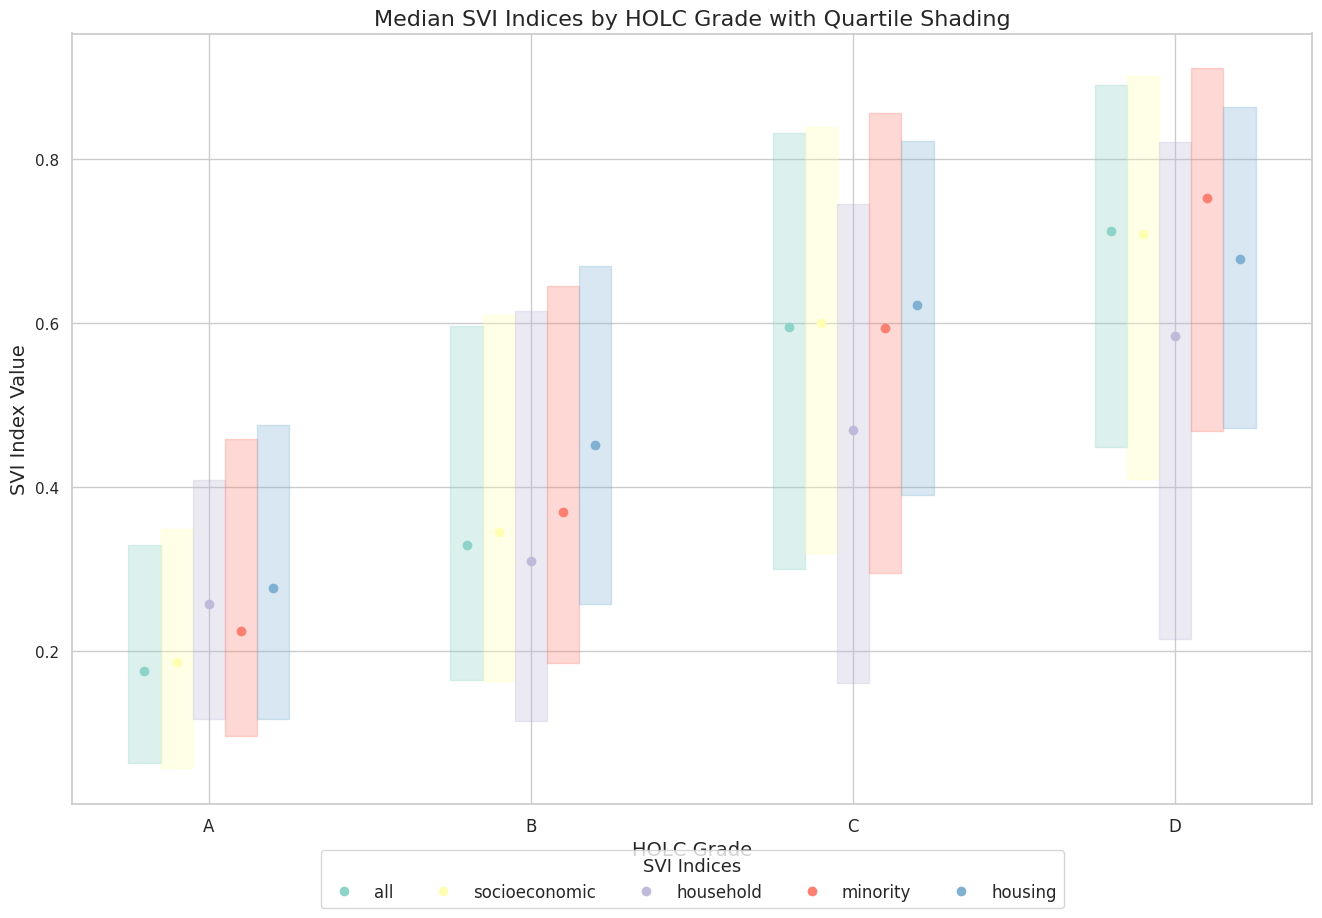

In [125]:
# Setting the seaborn style
sns.set(style="whitegrid")

# Preparing the data (assuming the initial filtering for 0 <= SVI <= 1 has been done)
# Assume 'filtered_df' is your DataFrame ready for this analysis

# Define the variables to analyze
variables = ['all', 'socioeconomic', 'household', 'minority', 'housing']

# Set up the plot
plt.figure(figsize=(16, 10))
palette = sns.color_palette("Set3", n_colors=len(variables))

# Loop through each variable to calculate statistics and plot
for i, variable in enumerate(variables):
    # Calculate median, Q1, and Q3 for each holc_grade within the current variable
    grouped = filtered_df.groupby('holc_grade')[variable].agg(['median', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)]).reset_index()
    grouped.columns = ['holc_grade', 'Median', 'Q1', 'Q3']

    # Adjusting plot positions for clarity
    positions = np.arange(len(grouped['holc_grade'])) + i*(0.1) - (0.2)

    # Plotting median values
    plt.plot(positions, grouped['Median'], marker='o', linestyle='', color=palette[i], label=variable)

    # Adding shading for Q1 to Q3
    for pos, q1, q3 in zip(positions, grouped['Q1'], grouped['Q3']):
        plt.fill_betweenx([q1, q3], pos-0.05, pos+0.05, color=palette[i], alpha=0.3)

# Customizing the plot
plt.title('Median SVI Indices by HOLC Grade with Quartile Shading', fontsize=16)
plt.xticks(ticks=np.arange(len(grouped['holc_grade'])), labels=grouped['holc_grade'], fontsize=12)
plt.xlabel('HOLC Grade', fontsize=14)
plt.ylabel('SVI Index Value', fontsize=14)
plt.legend(title='SVI Indices', loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize=12, title_fontsize='13', ncol=len(variables))

plt.show()


<ipython-input-126-9ae856bf7ab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['holc_grade_numeric'] = filtered_df['holc_grade'].map(grade_mapping)
<ipython-input-126-9ae856bf7ab2>:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=filtered_df, x='holc_grade_numeric', y=variable, marker='o',
<ipython-input-126-9ae856bf7ab2>:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=filtered_df, x='holc_grade_numeric', y=variable, marker='o',
<ipython-input-126-9ae856bf7ab2>:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=filtered_df, x='holc_

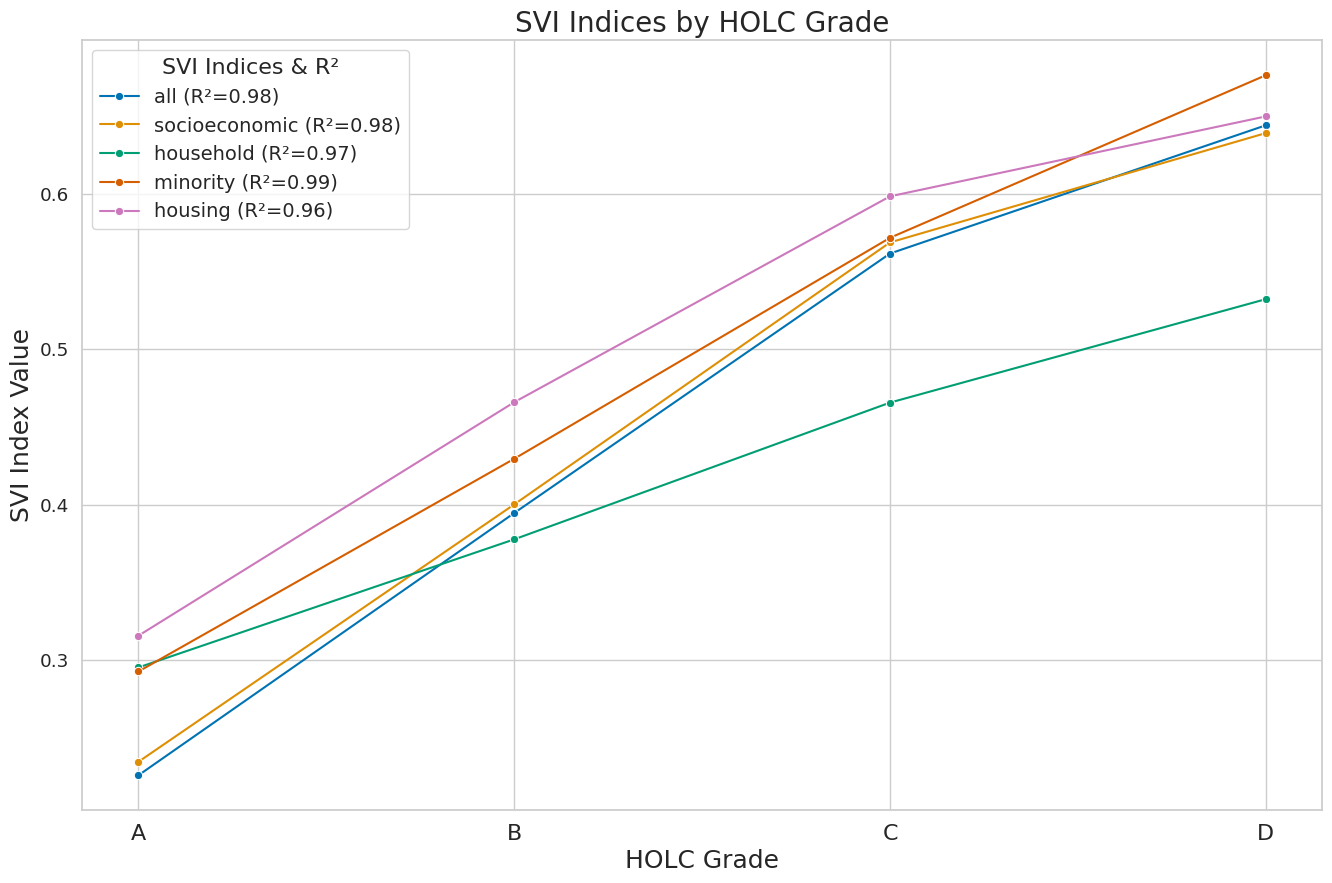

In [126]:
# Setting the seaborn style for better readability and colorblind-friendly palette
sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("colorblind", n_colors=5)  # Colorblind-friendly palette

# Mapping HOLC grades to numeric values
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
filtered_df['holc_grade_numeric'] = filtered_df['holc_grade'].map(grade_mapping)

# Define the variables to analyze
variables = ['all', 'socioeconomic', 'household', 'minority', 'housing']
r_squared_values = {}

# Start plotting
plt.figure(figsize=(16, 10))

for i, variable in enumerate(variables):
    # Group by holc_grade_num to calculate median for plotting
    grouped = filtered_df.groupby('holc_grade_numeric')[variable].median().reset_index()

    # Calculate Pearson correlation coefficient
    corr, _ = pearsonr(grouped['holc_grade_numeric'], grouped[variable])
    r_squared = corr**2
    r_squared_values[variable] = r_squared

    sns.lineplot(data=filtered_df, x='holc_grade_numeric', y=variable, marker='o',
                 linestyle='-', color=palette[i], label=f"{variable} (R²={r_squared_values[variable]:.2f})", ci=None)

# Customizing the plot
plt.title('SVI Indices by HOLC Grade', fontsize=20)
plt.xticks(ticks=np.arange(1, 5), labels=['A', 'B', 'C', 'D'], fontsize=16)
plt.xlabel('HOLC Grade', fontsize=18)
plt.ylabel('SVI Index Value', fontsize=18)
plt.legend(title='SVI Indices & R²', loc='upper left', fontsize=14, title_fontsize='16')

plt.show()

In [127]:
# Assuming 'df_rlsvi' is your DataFrame and it has been properly loaded and processed.
# Filtering data for grades A and D only
a_grade = df_rlsvi[df_rlsvi['holc_grade'] == 'A']
d_grade = df_rlsvi[df_rlsvi['holc_grade'] == 'D']

# List of RPL themes to test
themes = ['all', 'socioeconomic', 'household', 'minority', 'housing']

# Initializing a dictionary to store the p-values
p_values = {}

for theme in themes:
    # Perform the t-test between A and D grades for the current theme
    t_stat, p_val = ttest_ind(a_grade[theme].dropna(), d_grade[theme].dropna(), equal_var=False)
    p_values[theme] = p_val

# Display the p-values
for theme, p_val in p_values.items():
    print(f"{theme}: p-value = {p_val}")

all: p-value = 6.344221341186663e-138
socioeconomic: p-value = 4.7004942275376096e-142
household: p-value = 1.4176389327722886e-57
minority: p-value = 1.4134952489040377e-108
housing: p-value = 2.156734882075897e-93


# Statistics using moments of the SVI distribution

First, we have to design a population-weighting scheme to avoid giving too much weight to zipcodes that have very few patients over the 2016-2020 periods. To do this, we will weigh our correlations by 2016-2019 average patient population over the six weeks of interest (10-15).

### Correlation bar plots

In [128]:
#@title Weighted mean, covariance, and Pearson correlation functions
# From https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
def w_m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def w_cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - w_m(x, w)) * (y - w_m(y, w))) / np.sum(w)

def w_corr(x, y, w):
    """Weighted Correlation"""
    return w_cov(x, y, w) / np.sqrt(w_cov(x, x, w) * w_cov(y, y, w))

In [129]:
#@title Weighted Pearson correlation of `key_interest` with all keys in the dictionary
def w_corr_dic(dic, key_interest, weighting_key=None, keys_to_exclude=None):
  w_corr_dic = {} # Initialize the dictionary
  # Make a copy of dic.keys() and then exclude all the items in key_to_exclude from it
  if keys_to_exclude: filtered_keys = {key: dic[key] for key in dic if key not in keys_to_exclude}
  else: filtered_keys = dic
  # Calculate weighted correlations; use uniform weightining if w_key argument is None
  for key in filtered_keys:
    if weighting_key:
      w_corr_dic[key] = w_corr(dic[key_interest], dic[key], dic[weighting_key])
    else:
      w_corr_dic[key] = w_corr(dic[key_interest], dic[key], dic[key_interest]**0)

  return w_corr_dic

In [130]:
#@title Plotting routines for correlations
def plot_correlations(correlation_dictionary, **kwargs):
  fig,ax = plt.subplots(figsize=(12.5,5))
  # Sort correlations
  cor_sorted = sorted(correlation_dictionary.items(), key=lambda x: x[1])
  # extract labels and values
  labels = [value[0] for value in cor_sorted]
  values = [value[1] for value in cor_sorted]

  # create a horizontal bar plot
  plt.barh(labels, values)

  # add labels and title
  title_0 = 'Correlations'
  for key, value in kwargs.items():
    title_0 += ' '; title_0 += value;
  plt.xlabel('Pearson correlation')
  plt.title(title_0)

  return fig,ax

Use the short call below to plot the correlation of any key with respect to other keys, using the key you would like to weigh the statistics (use `weighting_key= None` for no weighting).

In [131]:
# Print available keys
print(svi_zip_diff.keys())

Index(['zip', 'zipcode', 'all_median', 'socioeconomic_median',
       'household_median', 'minority_median', 'housing_median', 'all_mean',
       'socioeconomic_mean', 'household_mean', 'minority_mean', 'housing_mean',
       'all_min', 'socioeconomic_min', 'household_min', 'minority_min',
       'housing_min', 'all_max', 'socioeconomic_max', 'household_max',
       'minority_max', 'housing_max', '2016-2019', '2020', 'six-week-diff',
       'drop_in_patients', 'relative_drop'],
      dtype='object')


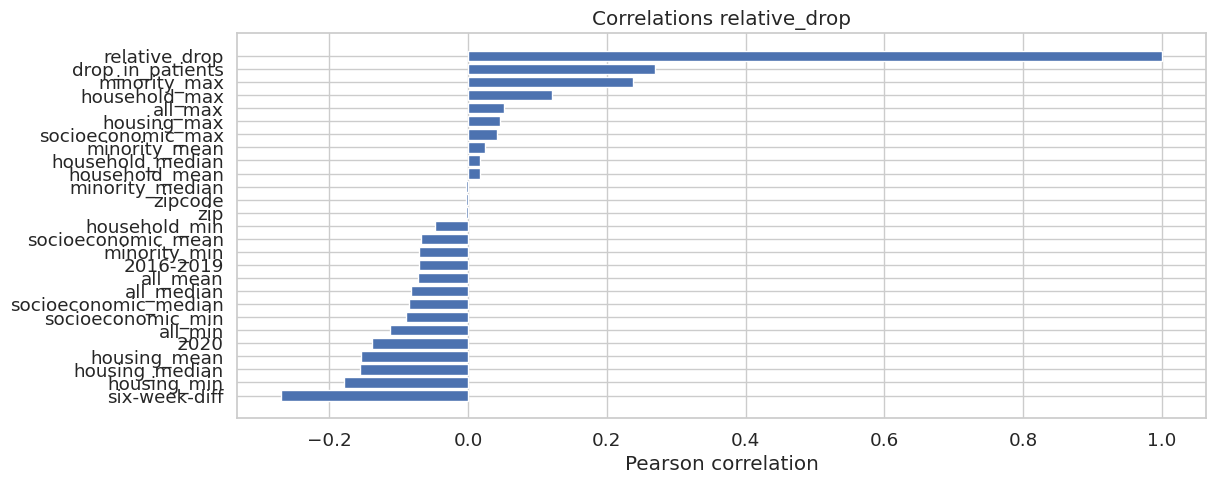

In [132]:
key_interest = 'relative_drop' # Key of interest for correlations

plot_correlations(w_corr_dic(dic = svi_zip_diff,
                             key_interest = key_interest),
                  title = key_interest);

### Stratified box and correlation plots to control for confounding variables

In [133]:
#@title Function to output box/correlation plots of a controlled variable of interest,
# with the data stratified using a potentially confounding variable
def stratified_plot(dic, key_stratification, key_interest, n_folds=5, **kwargs):
  '''
  dic: Dictionary containing the data
  key_stratification: Key used to stratify the data
  key_interest: Key of interest for the study
  n_folds: Number of stratification folds
  '''
  # Divide rows of dic into n_folds folds of dic[key_stratification]
  folds = pd.qcut(dic[key_stratification], q=n_folds, labels=False)
  dic['folds'] = folds

  # Extract min and max of each quintile group
  folds_min = dic.groupby('folds')[key_stratification].min()
  folds_max = dic.groupby('folds')[key_stratification].max()
  # Use it to create labels describing the range for each quintile
  folds_labels = [str(folds_min[i])[:(n_folds-1)]+'-'\
                  +str(folds_max[i])[:(n_folds-1)] for i in range(n_folds)]

  fig,ax = plt.subplots(n_folds+1, 1, figsize=(10,7.5*(n_folds+1)))

  # Box plot of key_interest stratified using key_stratification
  sns.boxplot(x = 'folds', y = key_interest, data = dic,
              notch=True, ax=ax[0])
  # Polish the plot
  ax[0].set_title(key_interest + ' stratified using ' + str(n_folds) + \
                  ' quantiles of ' + key_stratification, fontsize=14)
  ax[0].set_xlabel(str(n_folds)+" quantiles of "+key_stratification)
  ax[0].set_ylabel(key_interest)
  # Set style
  sns.set_style("whitegrid")
  ax[0].set_xticklabels(folds_labels)
  ax[0].tick_params(axis='x', rotation=30)

  # Correlation plot of key_interest inside each key_stratification fold
  for iax in range(n_folds):
    corr_dic = w_corr_dic(dic = dic[dic['folds'] == iax].copy(),
                          key_interest = key_interest,
                          weighting_key = None, keys_to_exclude = ['folds']);
    # Sort correlations
    cor_sorted = sorted(corr_dic.items(), key=lambda x: x[1])
    # extract labels and values
    labels = [value[0] for value in cor_sorted]
    values = [value[1] for value in cor_sorted]
    # create a horizontal bar plot
    ax[iax+1].barh(labels, values)
    # add labels and titles
    ax[iax+1].set_title('Correlations for ' + key_interest + ' in fold ' + \
                        str(iax+1) + ' of variable ' + key_stratification)
    ax[iax+1].set_xlabel('Pearson correlation')

  return fig,ax

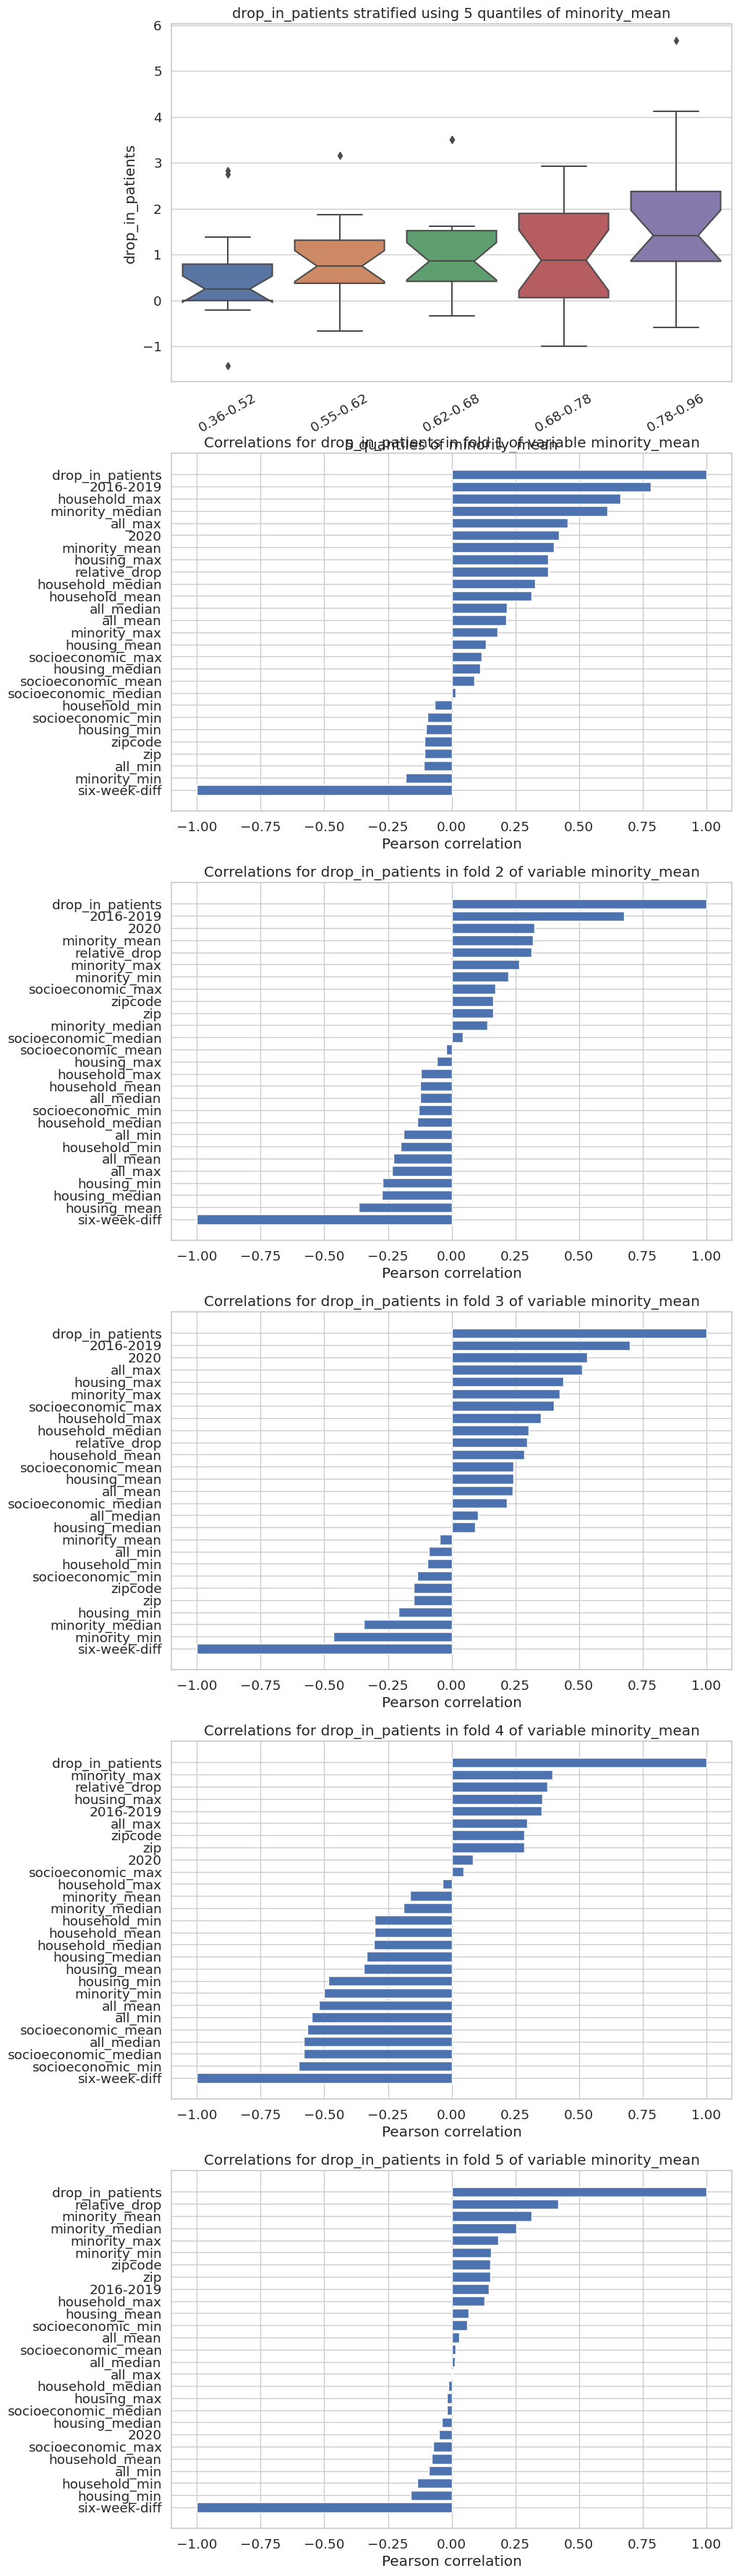

In [134]:
stratified_plot(svi_zip_diff, 'minority_mean', 'drop_in_patients', n_folds=5);

# Statistics using the full SVI distribution

## Stratify by drop in patients and use full distribution of SVI per zipcode

In [135]:
#@title Function grouping the SVI of *all* voting districts within a zipcode based on a variable of interest
def edg2bin(edges):
  return (edges[:-1] + edges[1:])/2

def svi_distributions(dic, svi = svi, key_interest = 'drop_in_patients',
                      n_folds = 3, n_bins = np.linspace(0,1,11),
                      plot_option = 'bar'):

  # 1. Calculate the folds based on key_interest
  folds = pd.qcut(dic[key_interest], q=n_folds, labels=False)
  dic['folds'] = folds

  # Extract min and max of each quintile group
  folds_min = dic.groupby('folds')[key_interest].min()
  folds_max = dic.groupby('folds')[key_interest].max()
  # Use it to create labels describing the range for each quintile
  folds_labels = [str(folds_min[i])[:(n_folds-1)]+'-'\
                  +str(folds_max[i])[:(n_folds-1)] for i in range(n_folds)]

  # 2. In each fold, calculate distribution of svi
  # 2.1 Identify the zipcodes in a fold of svi_zip_diff
  # 2.2 Then using the zipcodes, gather all the SVIs from svi
  fold_zipcodes = {};
  sviL = {}; # Initialize list of zipcodes
  svi_hist = {}; # Initialize histogram

  for i in range(n_folds):
    fold_zipcodes[i] = dic[dic['folds'] == i]['zipcode'].tolist()

    sviL[i] = {} # Initialize a dictionary for each SVI
    # For all the zipcodes in fold_zipcodes[i], list all the svi['RPL_THEMES']
    sviL[i]['all'] = np.array(svi[svi['zip'].isin(fold_zipcodes[i])]['RPL_THEMES'].tolist())
    sviL[i]['socioeconomic'] = np.array(svi[svi['zip'].isin(fold_zipcodes[i])]['RPL_THEME1'].tolist())
    sviL[i]['household'] = np.array(svi[svi['zip'].isin(fold_zipcodes[i])]['RPL_THEME2'].tolist())
    sviL[i]['minority'] = np.array(svi[svi['zip'].isin(fold_zipcodes[i])]['RPL_THEME3'].tolist())
    sviL[i]['housing'] = np.array(svi[svi['zip'].isin(fold_zipcodes[i])]['RPL_THEME4'].tolist())

    svi_hist[i] = {} # Initialize a dictionary for each SVI's histogram
    # For each category, calculate a histogram
    for svi_cat in ['all','socioeconomic','household','minority','housing']:
      svi_hist[i][svi_cat] = np.histogram(sviL[i][svi_cat]\
      [~np.isnan(sviL[i][svi_cat])], bins=n_bins)

  # 3. Plot it all as a function of the SVI
  fig, ax = plt.subplots(5,1,figsize=(15,20))
  for isvi, svi_cat in enumerate(['all','socioeconomic','household','minority','housing']):
    for i in range(n_folds):
      if plot_option == 'bar':
        wid = 0.75*(svi_hist[i][svi_cat][1][1] - svi_hist[i][svi_cat][1][0])/n_folds
        ax[isvi].bar(x = edg2bin(svi_hist[i][svi_cat][1]) + (i+0.5-n_folds/2)*wid,
                    align = 'center',
                    height = svi_hist[i][svi_cat][0], width = wid, bottom = 0,
                    label='Drop: '+folds_labels[i], alpha=0.5)
      elif plot_option == 'line':
        ax[isvi].scatter(edg2bin(svi_hist[i][svi_cat][1]), svi_hist[i][svi_cat][0])
        ax[isvi].plot(edg2bin(svi_hist[i][svi_cat][1]), svi_hist[i][svi_cat][0],
                      label='Drop: '+folds_labels[i])
      if isvi==0: ax[isvi].legend(loc='upper center')

    ax[isvi].set_xlim((np.min(svi_hist[i][svi_cat][1]),np.max(svi_hist[i][svi_cat][1])))
    ax[isvi].set_ylabel('Count'); ax[isvi].set_xlabel(svi_cat + 'SVI')

  return fig, ax, folds_labels, fold_zipcodes, sviL, svi_hist

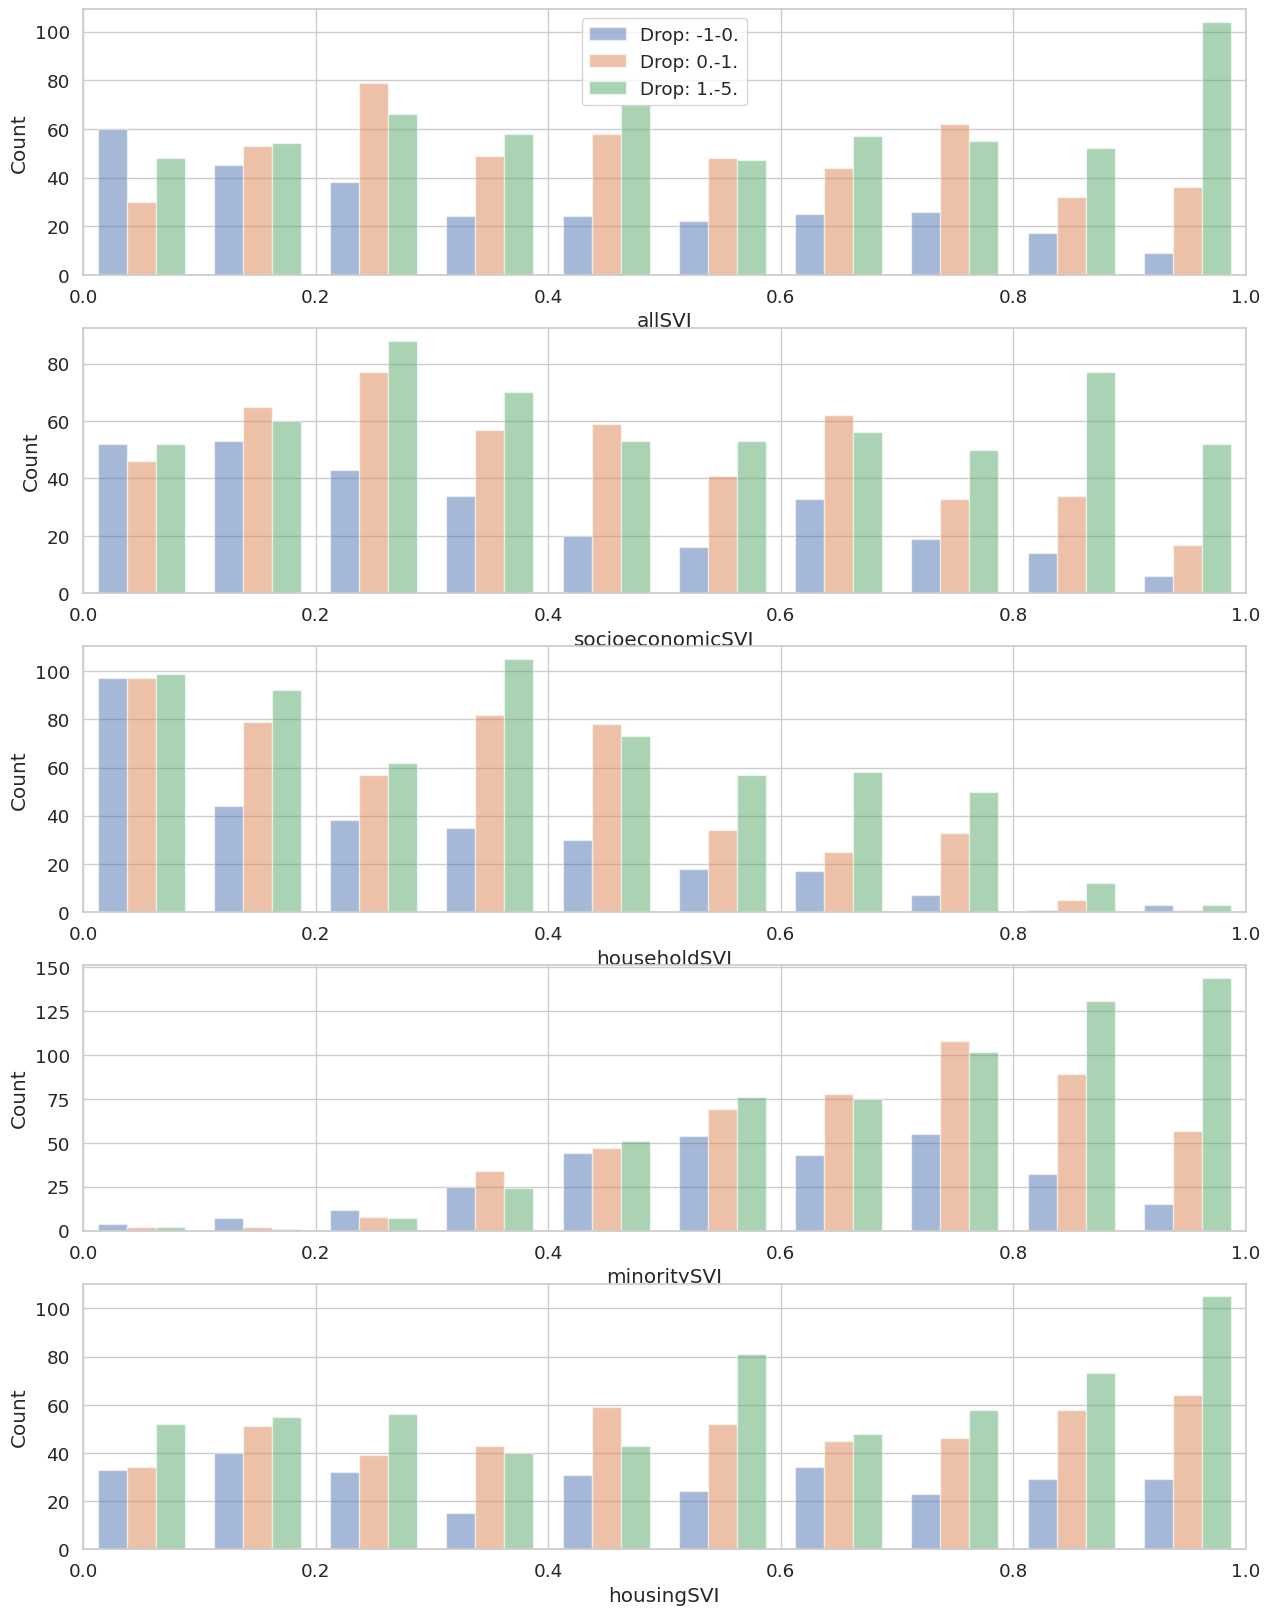

In [136]:
svi_distributions(dic = svi_zip_diff, svi = svi, key_interest = 'drop_in_patients',
                  n_folds = 3, n_bins = np.linspace(0,1,11),
                  plot_option = 'bar');

## Statistics based on the quintiles of the minority SVI distribution

In [137]:
svi_zip_diff

,zip,zipcode,all_median,socioeconomic_median,household_median,minority_median,housing_median,all_mean,socioeconomic_mean,household_mean,...,socioeconomic_max,household_max,minority_max,housing_max,2016-2019,2020,six-week-diff,drop_in_patients,relative_drop,folds
0,91901,91901,0.38795,0.28905,0.38515,0.44100,0.59420,0.428870,0.366560,0.443270,...,0.8475,0.8136,0.7920,0.9430,9.75,8.0,-1.75,0.291667,17.948718,0
1,91902,91902,0.51755,0.46755,0.35670,0.84025,0.40375,0.507744,0.474125,0.376481,...,0.8807,0.7691,0.9142,0.9454,10.25,5.0,-5.25,0.875000,51.219512,1
2,91905,91905,0.80845,0.75235,0.62790,0.70150,0.78365,0.808450,0.752350,0.627900,...,0.8475,0.6878,0.7778,0.9036,1.25,0.0,-1.25,0.208333,100.000000,0
3,91906,91906,0.83760,0.84750,0.68780,0.77780,0.66370,0.837600,0.847500,0.687800,...,0.8475,0.6878,0.7778,0.6637,4.50,4.0,-0.50,0.083333,11.111111,0
4,91910,91910,0.69390,0.68145,0.37715,0.86045,0.59090,0.675521,0.636925,0.442382,...,0.9723,0.9950,0.9622,0.9983,84.00,63.0,-21.00,3.500000,25.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,92131,92131,0.20050,0.19295,0.16240,0.63295,0.17115,0.206017,0.206117,0.256508,...,0.5656,0.5941,0.8257,0.5164,17.25,8.0,-9.25,1.541667,53.623188,2
90,92139,92139,0.70940,0.67505,0.38855,0.87800,0.55660,0.692593,0.668193,0.387764,...,0.9094,0.7746,0.9365,0.9760,43.50,29.0,-14.50,2.416667,33.333333,2
91,92145,92145,0.23980,0.21230,0.17860,0.56780,0.50250,0.262844,0.228556,0.176700,...,0.4732,0.5594,0.8471,0.9059,0.25,0.0,-0.25,0.041667,100.000000,0
92,92154,92154,0.81530,0.81225,0.54325,0.94110,0.75375,0.796042,0.758950,0.478185,...,0.9841,0.9676,0.9919,0.9755,95.00,61.0,-34.00,5.666667,35.789474,2


In [138]:
# Define the color codes for each quintile
colors_rgb = [
    [191, 219, 255],  # Q1
    [210, 249, 191],  # Q2
    [255, 255, 191],  # Q3
    [255, 234, 191],  # Q4
    [255, 191, 191]   # Q5
]

# Convert RGB to normalized RGB (0-1 range for matplotlib)
colors_norm = [(r/255, g/255, b/255) for r, g, b in colors_rgb]

# Create a palette dictionary mapping quintile numbers to colors
palette = {i: colors_norm[i] for i in range(5)}

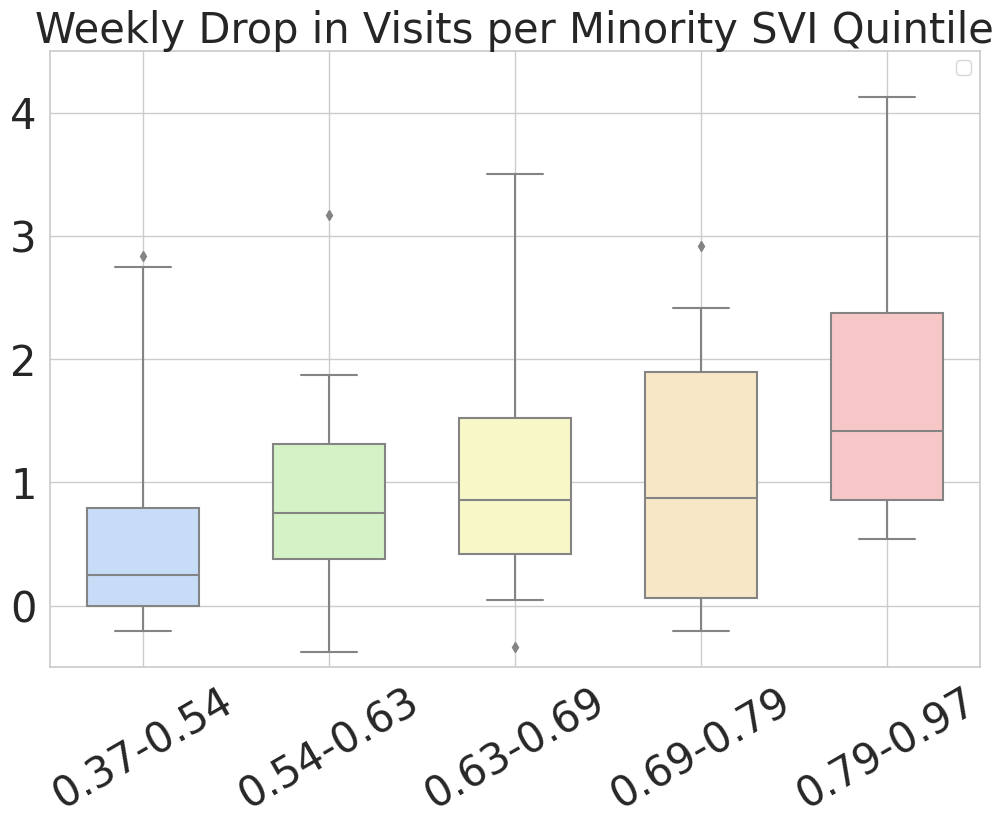

In [139]:
# Assuming svi_zip_diff is your original DataFrame and it's already loaded
df0 = svi_zip_diff.copy()
df0['minority_SVI_quintile'] = pd.qcut(svi_zip_diff['minority_mean'], 5, labels=False)

# Obtain the edges of the bins to create meaningful labels
quintile_edges = pd.qcut(svi_zip_diff['minority_mean'], 5, retbins=True)[1]

# Create labels based on the quintile edges
quintile_labels = [f'{quintile_edges[i]:.2f}-{quintile_edges[i+1]:.2f}' for i in range(len(quintile_edges)-1)]

# Define your color palette as before, assuming 'palette' is already defined

# Now, adjust the boxplot to match the provided conventions
plt.figure(figsize=(12, 8))
sns.boxplot(x='minority_SVI_quintile', y='drop_in_patients', data=df0, palette=palette,
            whis=[2.5, 97.5],  # Set whiskers to the 2.5th and 97.5th percentiles
            width=0.6)  # Control box width

# Since we're not using 'hue' and 'labels' inside each box from the original instructions,
# we'll skip those parts. Instead, focus on adjusting the aesthetics to match the provided conventions.

plt.title('Weekly Drop in Visits per Minority SVI Quintile',fontsize=30)  # Title is omitted as per instructions
plt.xlabel('')  # Remove the x-label as per instructions
plt.ylabel('', fontsize=30)  # Adjust the y-label and font size
plt.ylim((-0.5,4.5))

# Adjust the font size for x and y tick labels
plt.xticks(np.arange(5), quintile_labels, fontsize=30, rotation=30)  # Tilt the x-labels by 45 degrees
plt.yticks(fontsize=30)  # Increase font size for y tick labels

plt.grid(True)  # Ensure the grid is displayed

# Hide the legend, as we're not using 'hue'
plt.legend('')  # to avoid redundancy in the final figure

plt.show()

In [140]:
median_drop_in_patients_per_quintile = df0.groupby('minority_SVI_quintile')['drop_in_patients'].median()
print(median_drop_in_patients_per_quintile)

minority_SVI_quintile
0    0.250000
1    0.750000
2    0.854167
3    0.875000
4    1.416667
Name: drop_in_patients, dtype: float64


In [141]:
# Filter the DataFrame for the lowest and highest minority SVI quintiles
lowest_quintile = df0[df0['minority_SVI_quintile'] == 0]['drop_in_patients']
highest_quintile = df0[df0['minority_SVI_quintile'] == 4]['drop_in_patients']

# Perform the t-test
t_stat, p_value = ttest_ind(lowest_quintile, highest_quintile)

# Print the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print("Reject the null hypothesis - There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis - There is no significant difference between the groups.")

T-statistic: -3.197868329575925
P-value: 0.002883758818960416
Reject the null hypothesis - There is a significant difference between the groups.
